<a href="https://colab.research.google.com/github/GAMZAMANDU/gukjeung24/blob/main/%E1%84%80%E1%85%AE%E1%86%A8%E1%84%92%E1%85%AC%E1%84%8B%E1%85%B4%E1%84%8B%E1%85%A1%E1%86%AB%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8%E1%84%92%E1%85%A1%E1%84%83%E1%85%A1_%E1%84%80%E1%85%AE%E1%86%A8%E1%84%8C%E1%85%A5%E1%86%BC24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 국회의안 데이터 분석 프로젝트 - 국정24

## 프로젝트 개요
본 프로젝트는 국회 Open API를 활용하여 22대 국회 의원들의 정책 분야별 활동을 분석하는 프로젝트입니다.

### 분석 목표
- 국회 의원별 정책 분야 집중도 분석한다
- 정책 분야별 활동 현황 파악한다
- 의원별 발의 의안 특성 분석한다

### 분석 과정
1. **데이터 전처리**: Open API 데이터 수집 및 정제
2. **데이터 분석**: 의원별 정책 분야 점수 계산
3. **데이터 시각화**: 히트맵을 통한 시각적 분석


# 1. 데이터 전처리 (Data Preprocessing)

## 1.1 필요한 라이브러리 임포트

In [44]:
import requests
import pandas as pd
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import platform


plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

print("라이브러리 임포트 및 한글 폰트 설정 완료")

라이브러리 임포트 및 한글 폰트 설정 완료


## 1.2 API 설정 및 연결 테스트

In [45]:
API_KEY = ""
BILL_URL = "https://open.assembly.go.kr/portal/openapi/nwbpacrgavhjryiph"
VOTE_URL = "https://open.assembly.go.kr/portal/openapi/ncocpgfiaoituanbr"
MEMBER_URL = "https://open.assembly.go.kr/portal/openapi/nwbpacrgavhjryiph"

def test_api():
    print("=== 국회 Open API 연결 테스트 ===")

    params = {
        'Key': API_KEY,
        'Type': 'json',
        'pIndex': 1,
        'pSize': 5,
        'AGE': '22'
    }

    try:
        response = requests.get(BILL_URL, params=params)
        print(f"API 응답 상태: {response.status_code}")

        if response.status_code == 200:
            data = response.json()
            print("✅ API 연결 성공!")
            print(f"응답 데이터 구조 키들: {list(data.keys())}")
            return True, data
        else:
            print(f"❌ API 연결 실패: {response.text}")
            return False, None

    except Exception as e:
        print(f"❌ API 연결 중 오류 발생: {e}")
        return False, None

success, sample_data = test_api()

=== 국회 Open API 연결 테스트 ===
API 응답 상태: 200
✅ API 연결 성공!
응답 데이터 구조 키들: ['nwbpacrgavhjryiph']


## 1.3 데이터 수집 및 정제

In [46]:
def collect_bills(max_pages=3):
    print("=== 국회 의안 데이터 수집 시작 ===")
    all_bills = []

    for page in range(1, max_pages + 1):
        params = {
            'Key': API_KEY,
            'Type': 'json',
            'pIndex': page,
            'pSize': 100,
            'AGE': '22'
        }

        try:
            response = requests.get(BILL_URL, params=params)

            if response.status_code == 200:
                data = response.json()
                bills = data['nwbpacrgavhjryiph'][1]['row']
                all_bills.extend(bills)
                print(f"📄 페이지 {page}: {len(bills)}건 수집")
            else:
                print(f"❌ 페이지 {page} 수집 실패")
                break

        except Exception as e:
            print(f"❌ 페이지 {page} 수집 중 오류: {e}")
            break

    print(f"✅ 총 수집된 의안 데이터: {len(all_bills)}건")
    return all_bills

bills_data = collect_bills(max_pages=3)

=== 국회 의안 데이터 수집 시작 ===
📄 페이지 1: 100건 수집
📄 페이지 2: 100건 수집
📄 페이지 3: 100건 수집
✅ 총 수집된 의안 데이터: 300건


In [57]:
def extract_proposer(text):
    if pd.isna(text) or '의원' not in text:
        return None

    if '등' in text:
        main = text.split('등')[0].strip()
        if '의원' in main:
            return main
    else:
        if text.endswith('의원'):
            return text

    return None

def organize_bills(bills_data):
    df = pd.DataFrame(bills_data)
    print(f"📊 전체 의안 데이터: {len(df)}건")

    df['proposer'] = df['PROPOSER'].apply(extract_proposer)

    df_valid = df.dropna(subset=['proposer']).copy()
    print(f"📊 주발의자가 명확한 의안: {len(df_valid)}건")

    bill_counts = df_valid['proposer'].value_counts().to_dict() # Simplified bill_counts creation
    print(f"📊 개별 의원 수: {len(bill_counts)}명")

    return df, bill_counts, df_valid # Return df_valid which is already a DataFrame
bills_df, bill_counts, all_proposer_df = organize_bills(bills_data) # Renamed active_df to all_proposer_df

📊 전체 의안 데이터: 300건
📊 주발의자가 명확한 의안: 91건
📊 개별 의원 수: 73명


# 2. 데이터 분석 (Data Analysis)

## 2.1 기초 데이터 탐색

In [48]:
print("=== 데이터 개요 ===")
print(f"📊 총 수집된 의안: {len(bills_df)}건")
print(f"👥 전체 의원 수: {len(bill_counts)}명")


print("\n=== 의원별 발의 현황 (전체 의원) ===") # Updated title
# top_proposers = all_proposer_df['proposer'].value_counts().sort_values(ascending=False).head(100) # Removed .head(100)
top_proposers = all_proposer_df['proposer'].value_counts().sort_values(ascending=False)
for i, (member, count) in enumerate(top_proposers.items(), 1):
    print(f"{i:2d}. {member}: {count}건")

print("\n=== 실제 의안 예시 ===")
sample_bills = bills_df[['BILL_NM', 'PROPOSER', 'PROPOSE_DT']].head(5)
for i, (_, row) in enumerate(sample_bills.iterrows(), 1):
    print(f"{i}. {row['BILL_NM']}")
    print(f"   제안자: {row['PROPOSER']}")
    print(f"   제안일: {row['PROPOSE_DT']}")
    print()

print("=== 추가 통계 정보 ===")
print(f"📈 의안 처리 현황:")
proc_counts = bills_df['PROC_RESULT_CD'].value_counts()
for result, count in proc_counts.head(5).items():
    print(f"- {result}: {count}건")

print(f"\n📅 연도별 의안 발의 현황:")
bills_df['year'] = pd.to_datetime(bills_df['PROPOSE_DT'], errors='coerce').dt.year
yearly_counts = bills_df['year'].value_counts().sort_index()
for year, count in yearly_counts.items():
    if pd.notna(year):
        print(f"- {int(year)}년: {count}건")

=== 데이터 개요 ===
📊 총 수집된 의안: 300건
👥 전체 의원 수: 73명

=== 의원별 발의 현황 (전체 의원) ===
 1. 김예지의원: 3건
 2. 백승아의원: 3건
 3. 정을호의원: 3건
 4. 이원택의원: 2건
 5. 조계원의원: 2건
 6. 민형배의원: 2건
 7. 박용갑의원: 2건
 8. 김정호의원: 2건
 9. 김미애의원: 2건
10. 주철현의원: 2건
11. 강선우의원: 2건
12. 김성원의원: 2건
13. 최보윤의원: 2건
14. 서명옥의원: 2건
15. 임오경의원: 2건
16. 서천호의원: 1건
17. 김준형의원: 1건
18. 이개호의원: 1건
19. 이강일의원: 1건
20. 양문석의원: 1건
21. 박범계의원: 1건
22. 조인철의원: 1건
23. 권영진의원: 1건
24. 오세희의원: 1건
25. 김용민의원: 1건
26. 김종민의원: 1건
27. 박홍배의원: 1건
28. 김남희의원: 1건
29. 염태영의원: 1건
30. 이기헌의원: 1건
31. 이언주의원: 1건
32. 허종식의원: 1건
33. 김용태의원ㆍ강경숙의원: 1건
34. 김문수의원: 1건
35. 허영의원: 1건
36. 박상웅의원: 1건
37. 박희승의원: 1건
38. 박균택의원: 1건
39. 장종태의원: 1건
40. 맹성규의원: 1건
41. 민병덕의원: 1건
42. 윤재옥의원: 1건
43. 이해식의원: 1건
44. 강대식의원: 1건
45. 정희용의원: 1건
46. 박정하의원: 1건
47. 황희의원: 1건
48. 이달희의원: 1건
49. 안규백의원: 1건
50. 윤종오의원: 1건
51. 강선영의원: 1건
52. 이헌승의원: 1건
53. 우재준의원: 1건
54. 정연욱의원: 1건
55. 김원이의원: 1건
56. 엄태영의원: 1건
57. 김윤덕의원: 1건
58. 최형두의원: 1건
59. 조경태의원: 1건
60. 박형수의원: 1건
61. 이양수의원: 1건
62. 서영교의원: 1건
63. 박정의원: 1건
64. 진선미의원: 1건
65. 이용우의원: 1건
66. 김병주의원: 1건

## 2.2 정책 분야별 분석

In [49]:
policy_map = {
    '경제': ['경제', '산업', '기업', '투자', '금융', '무역', '상업', '시장', '예산', '세금', '세제'],
    '사회복지': ['복지', '사회', '보장', '지원', '급여', '연금', '의료', '건강', '보험', '돌봄'],
    '교육': ['교육', '학교', '대학', '학생', '교사', '학습', '연구', '도서관', '과학기술'],
    '환경': ['환경', '생태', '기후', '오염', '청정', '에너지', '탄소', '재생', '자연'],
    '국방안보': ['국방', '안보', '안전', '군사', '방위', '테러', '사이버', '정보보호'],
    '문화체육': ['문화', '체육', '예술', '관광', '스포츠', '영화', '음악', '방송', '언론'],
    '농업': ['농업', '농촌', '농민', '축산', '어업', '식품', '농산물', '축산물'],
    '교통': ['교통', '도로', '철도', '항공', '해운', '버스', '지하철', '교통비'],
    '외교': ['외교', '국제', '조약', '협정', '대외', '외국', '글로벌', '국경'],
    '법무': ['법', '법률', '사법', '재판', '검찰', '변호사', '인권', '형사', '민사']
}

def calc_score(bill_name, keywords):
    if pd.isna(bill_name):
        return 0
    return sum(1 for keyword in keywords if keyword in bill_name)

def calc_policy_scores(df):
    print("=== pandas를 활용한 의원별 정책 집중도 계산 ===")

    for area, keywords in policy_map.items():
        df[f'score_{area}'] = df['BILL_NM'].apply(
            lambda x: calc_score(x, keywords)
        )

    score_cols = [f'score_{area}' for area in policy_map.keys()]
    scores = df.groupby('proposer')[score_cols].sum()

    scores.columns = [col.replace('score_', '') for col in scores.columns]

    print(f"✅ {len(scores)}명 의원의 정책 점수 계산 완료")

    return scores


heatmap_df = calc_policy_scores(all_proposer_df.copy())

=== pandas를 활용한 의원별 정책 집중도 계산 ===
✅ 73명 의원의 정책 점수 계산 완료


# 3. 데이터 시각화 (Data Visualization)


In [50]:
def create_heatmap(df, title="의원별 정책 분야 집중도"):
    df_display = df.copy()
    df_display.index = [name[:13] + '..' if len(name) > 15 else name for name in df_display.index]

    fig = go.Figure(data=go.Heatmap(
        z=df_display.values,
        x=df_display.columns,
        y=df_display.index,
        colorscale='Blues',
        showscale=True,
        text=df_display.values,
        texttemplate="%{text:.0f}",
        textfont={"size": 10},
        hoverongaps=False,
        hovertemplate='의원: %{y}<br>정책분야: %{x}<br>점수: %{z:.0f}<extra></extra>'
    ))

    fig.update_layout(
        title=title,
        xaxis_title="정책 분야",
        yaxis_title="의원명",
        xaxis=dict(tickangle=45),
        yaxis=dict(tickangle=0),
        width=1000,
        height=800
    )

    return fig

fig = create_heatmap(heatmap_df)
fig.show()

print("✅ 인터랙티브 히트맵 생성 완료")

✅ 인터랙티브 히트맵 생성 완료


# 위원회와 의원 관심분야 순위 거리 분석

## 분석 목표
각 의원이 속한 위원회와 실제 관심분야 간의 순위 기반 거리를 계산하여 정책 효율성을 분석합니다.

### 분석 방법
1. 각 의원의 정책 분야별 점수를 높은 순으로 정렬
2. 해당 의원이 속한 위원회의 분야가 몇 번째 순위에 있는지 확인
3. 그 순위가 바로 "거리" (0번째가 가장 가까움, 9번째가 가장 멀음)

### 위원회-분야 매핑
- **경제**: 기획재정위원회, 산업통상자원중소벤처기업위원회
- **사회복지**: 보건복지위원회
- **교육**: 교육위원회
- **환경**: 환경노동위원회
- **국방안보**: 국방위원회, 정보위원회
- **문화체육**: 문화체육관광위원회
- **농업**: 농림축산식품해양수산위원회
- **교통**: 국토교통위원회
- **외교**: 외교통일위원회
- **법무**: 법제사법위원회, 행정안전위원회

In [51]:
import requests
import pandas as pd
import numpy as np
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import platform
import warnings

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

warnings.filterwarnings('ignore')

print("라이브러리 임포트 및 한글 폰트 설정 완료")

라이브러리 임포트 및 한글 폰트 설정 완료


In [52]:
committee_mapping = {
    "기획재정위원회": "경제", "산업통상자원중소벤처기업위원회": "경제",
    "보건복지위원회": "사회복지", "교육위원회": "교육", "환경노동위원회": "환경",
    "국방위원회": "국방안보", "정보위원회": "국방안보", "문화체육관광위원회": "문화체육",
    "농림축산식품해양수산위원회": "농업", "국토교통위원회": "교통", "외교통일위원회": "외교",
    "법제사법위원회": "법무", "행정안전위원회": "법무", "과학기술정보방송통신위원회": "경제",
    "여성가족위원회": "사회복지", "예산결산특별위원회": "경제", "윤리특별위원회": "법무"
}

In [59]:
with open('committee.json', 'r', encoding='utf-8') as f:
    committee_data = json.load(f)
# policy_df = pd.read_csv('final_real_member_policy_heatmap.csv', index_col=0) # Replaced with existing heatmap_df
policy_df = heatmap_df.copy()

ranking_df = policy_df.rank(axis=1, method='min', ascending=False) - 1

members_data = []
for committee, info in committee_data.items():
    field = committee_mapping.get(committee)
    if field:
        for member in info['members']:
            name = member['name'] + "의원"
            if name in policy_df.index:
                members_data.append({
                    'name': name, 'committee': committee, 'field': field,
                    'party': member['party']
                })

df = pd.DataFrame(members_data)
df['distance'] = df.apply(lambda x: ranking_df.loc[x['name'], x['field']], axis=1)


📊 정책 분야별 상세 분석:
       의원수  평균거리  표준편차  최소거리  최대거리
field                             
법무       7  0.00  0.00   0.0   0.0
교육       6  1.00  0.00   1.0   1.0
국방안보     8  1.00  0.00   1.0   1.0
외교       1  1.00   NaN   1.0   1.0
사회복지    13  1.15  0.69   0.0   2.0
경제      15  1.33  0.62   1.0   3.0
교통       7  1.43  0.53   1.0   2.0
문화체육     8  1.50  0.76   1.0   3.0
농업       5  1.60  0.89   1.0   3.0
환경       4  1.75  0.96   1.0   3.0
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


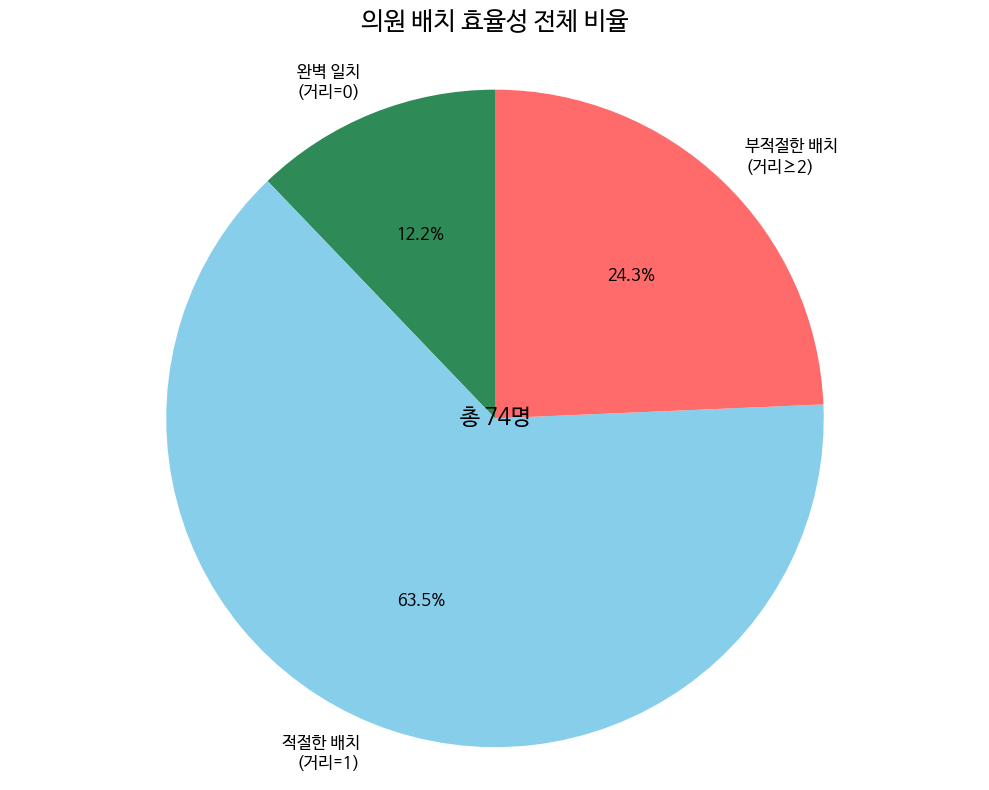


📊 관심사-위원회 일치도 분석 (비율 기준):
   • 총 의원 수: 74명
   • 완벽 일치 (거리=0): 9명 (12.2%)
   • 적절한 배치 (거리≤1): 56명 (75.7%)
   • 부적절한 배치 (거리≥2): 18명 (24.3%)
   • 평균 거리: 1.18
   • 전체 배치 효율성: 75.7%


In [56]:
if not df.empty:
    # 분야별 통계 요약
    print("\n📊 정책 분야별 상세 분석:")
    print("=" * 60)
    field_stats = df.groupby('field').agg({
        'distance': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)
    field_stats.columns = ['의원수', '평균거리', '표준편차', '최소거리', '최대거리']
    field_stats = field_stats.sort_values('평균거리')
    print(field_stats)

    # Install Korean font and configure matplotlib for this specific cell
    !apt-get update -qq
    !apt-get install fonts-nanum -qq

    import matplotlib.font_manager as fm
    fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    font = fm.FontProperties(fname=fontpath, size=12)

    fm.fontManager.addfont(fontpath)
    plt.rcParams['font.family'] = font.get_name()
    plt.rcParams['axes.unicode_minus'] = False


    # 파이차트로 전체 비율 한눈에 보기
    plt.figure(figsize=(10, 8))


    # 거리 범주별 그룹화
    total_members = len(df)
    categories = ['완벽 일치\n(거리=0)', '적절한 배치\n(거리=1)', '부적절한 배치\n(거리≥2)']
    perfect = len(df[df['distance'] == 0])
    good = len(df[df['distance'] == 1])
    poor = len(df[df['distance'] >= 2])
    values = [perfect, good, poor]
    colors_pie = ['#2E8B57', '#87CEEB', '#FF6B6B']

    wedges, texts, autotexts = plt.pie(values, labels=categories, colors=colors_pie, autopct='%1.1f%%',
                                   startangle=90, textprops={'fontsize': 12})


    plt.text(0, 0, f'총 {total_members}명', ha='center', va='center', fontsize=16, fontweight='bold')

    plt.title('의원 배치 효율성 전체 비율', fontsize=18, fontweight='bold', pad=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


    print(f"\n📊 관심사-위원회 일치도 분석 (비율 기준):")
    print(f"   • 총 의원 수: {total_members}명")
    print(f"   • 완벽 일치 (거리=0): {perfect}명 ({perfect/total_members*100:.1f}%)")
    print(f"   • 적절한 배치 (거리≤1): {perfect+good}명 ({(perfect+good)/total_members*100:.1f}%)")
    print(f"   • 부적절한 배치 (거리≥2): {poor}명 ({poor/total_members*100:.1f}%)")
    print(f"   • 평균 거리: {df['distance'].mean():.2f}")
    print(f"   • 전체 배치 효율성: {(perfect+good)/total_members*100:.1f}%")
else:
    print("Analysis and visualization skipped because 'df' is empty.")